In [132]:
import importlib.util
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [133]:
um = 1e-6
nm = 1e-9
valor_lambda = 1550*nm
start_wavelenth = 1500*nm
stop_wavelenth = 1600*nm
number_point = 1000
wg_width = 0.45*um
radius = 5*um
ng = 4.325928
Lc_pdk = 17.5*um

file = 'ring_ressonator_PDK'

In [134]:
FSR = [1*nm, 10*nm, 20*nm]

In [135]:
def calcular_Lc (valor_Lr):
    valor_Lc = valor_Lr - 2*np.pi*radius - 2*Lc_pdk
    return valor_Lc

In [136]:
def calcular_Lr (valor_Lc):
    Valor_Lr = 2*np.pi*radius + 2*valor_Lc + 2*Lc_pdk
    return Valor_Lr

In [137]:
def calcular_fsr (valor_Lr):
    valor_fsr = (valor_lambda**2) / (ng * valor_Lr)
    return valor_fsr

In [138]:
Lc1_values = np.linspace(35*um, 150*um, 10000)
Lc2_values = np.zeros(len(Lc1_values))

FSR_matrix = np.zeros(len(Lc1_values))

In [139]:
M = 7
N = 6

for i, Lc1 in enumerate(Lc1_values):
    Lr1 = calcular_Lr(Lc1)
    Lr2 = M/N * Lr1

    Lc2_values[i] = calcular_Lc(Lr2)

    FSR1 = calcular_fsr(Lr1)
    FSR2 = calcular_fsr(Lr2)

    FSR_total = abs(M - N) * (FSR1 * FSR2) / abs(FSR1 - FSR2)
    FSR_matrix[i] = FSR_total

In [140]:
Lc1 = np.zeros(len(FSR))
Lc2 = np.zeros(len(FSR))

N = [1, 2, 2]

for i in range (len(FSR)):
    Lr = (valor_lambda**2)/(ng*FSR[i])
    Lc1[i] = calcular_Lc(Lr)/2
    Lc2[i] = 0
    Lr = calcular_Lr(Lc1[i])

    for j in range (len(FSR)):
        if Lc1[i] < 0 or Lc2[i] < 0:            
            idx_min = np.argmin(np.abs(FSR_matrix - FSR[i]))
            Lc1[i] = Lc1_values[idx_min]/2 - Lc_pdk
            Lr1 = calcular_Lr(Lc1[i])
            Lc2[i] = Lc2_values[idx_min]/2 - Lc_pdk
            Lr2 = calcular_Lr(Lc2[i])

            erro = np.abs(FSR[i] - FSR_matrix[idx_min])/FSR[i]

            if Lc1[i] >= 0 and Lc2[i] >= 0:
                print(f'O erro entre o FSR calculado e o esperado é de: {erro*100:.4f}%')
                print(f'Para FSR = {FSR[i]/nm:.2f}nm:\nComprimento aproximado do anel 1 = {Lr1/um:.2f}\u03BCm\nComprimento aproximado do anel 2 = {Lr2/um:.2f}\u03BCm\nComprimento de acoplamento 1 aproximado = {Lc1[i]/um:.2f}\u03BCm\nComprimento de acoplamento 2 aproximado = {Lc2[i]/um:.2f}\u03BCm\n')
                break

        else:
            print(f'Para FSR = {FSR[i]/nm:.2f}nm:\nComprimento aproximado do anel = {Lr/um:.2f}\u03BCm\nComprimento de acoplamento aproximado = {Lc1[i]/um:.2f}\u03BCm\n')
            break

Lc = np.array([Lc1, Lc2])

Para FSR = 1.00nm:
Comprimento aproximado do anel = 555.37μm
Comprimento de acoplamento aproximado = 244.48μm

O erro entre o FSR calculado e o esperado é de: 0.0001%
Para FSR = 10.00nm:
Comprimento aproximado do anel 1 = 164.82μm
Comprimento aproximado do anel 2 = 353.76μm
Comprimento de acoplamento 1 aproximado = 49.20μm
Comprimento de acoplamento 2 aproximado = 143.67μm

O erro entre o FSR calculado e o esperado é de: 0.0038%
Para FSR = 20.00nm:
Comprimento aproximado do anel 1 = 81.52μm
Comprimento aproximado do anel 2 = 159.39μm
Comprimento de acoplamento 1 aproximado = 7.55μm
Comprimento de acoplamento 2 aproximado = 46.49μm



In [141]:
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

interApi = lumapi.INTERCONNECT(hide = False)

In [142]:
x_ona = 0
y_ona = 0

x_acoplador_direcional_sup = 20
y_acoplador_direcional_sup = 200

x_acoplador_direcional_inf = 20
y_acoplador_direcional_inf = 600

distancia = 200

x_waveguide_esquerdo = x_acoplador_direcional_sup - distancia
y_waveguide_esquerdo = y_acoplador_direcional_sup + distancia

x_waveguide_direito = x_acoplador_direcional_sup + distancia
y_waveguide_direito = y_acoplador_direcional_sup + distancia



In [143]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)

In [144]:
interApi.switchtolayout()
for i in range(N[0]):
    interApi.select(f'Acoplador_Direcional_sup_{N[i]}')
    interApi.delete()
    interApi.select(f'Acoplador_Direcional_inf_{N[i]}')
    interApi.delete()

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_sup_{N[i]}')
    interApi.setposition(f'Acoplador_Direcional_sup_{N[i]}', x_acoplador_direcional_sup, y_acoplador_direcional_sup)

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_inf_{N[i]}')
    interApi.setposition(f'Acoplador_Direcional_inf_{N[i]}', x_acoplador_direcional_inf, y_acoplador_direcional_inf)

In [145]:
interApi.switchtolayout()

for i in range(N[0]):
    interApi.select(f'WGD_esquerdo_{N[i]}')
    interApi.delete()
    interApi.select(f'WGD_direito_{N[i]}')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_esquerdo_{N[i]}')
    interApi.setposition(f'WGD_esquerdo_{N[i]}', x_waveguide_esquerdo, y_waveguide_esquerdo)
    interApi.set('wg_length', Lc[[i],[0]])
    interApi.set('wg_width', wg_width)
    interApi.set('Rotated', 45)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_direito_{N[i]}')
    interApi.setposition(f'WGD_direito_{N[i]}', x_waveguide_direito, y_waveguide_direito)
    interApi.set('wg_length', Lc[[i],[0]])
    interApi.set('wg_width', wg_width)
    interApi.set('Rotated', 45)

In [146]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_{N[0]}', 'opt_1')
for i in range (N[0]):
	if i == 0:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')
	
	elif N[i] > 1:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i-1]}', 'opt_3', f'Acoplador_Direcional_sup_{N[i]}', 'opt_1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')
		interApi.connect(f'Acoplador_Direcional_inf_{N[i-1]}', 'opt_4', f'Acoplador_Direcional_inf_{N[i]}', 'opt_2')
	else:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_{N[i]}', 'opt_2', 'ONA', 'input 2')

1.0

In [147]:
interApi.save(file)

In [148]:
interApi.run(1)

In [149]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
transmission_1 = np.array(FSR_1["'TE' gain (dB)"])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
transmission_2 = np.array(FSR_2["'TE' gain (dB)"])  

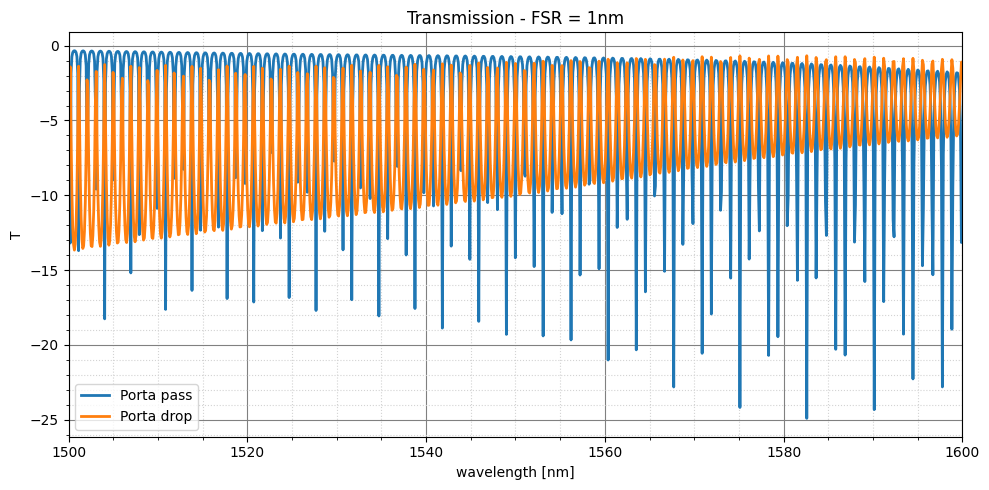

In [150]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - FSR = 1nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 1nm.png')
plt.show()

In [151]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_1 = np.array(FSR_1["'TE' free spectral range (m)"])

wavelength_2_1 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_1 = np.array(FSR_2["'TE' free spectral range (m)"])  

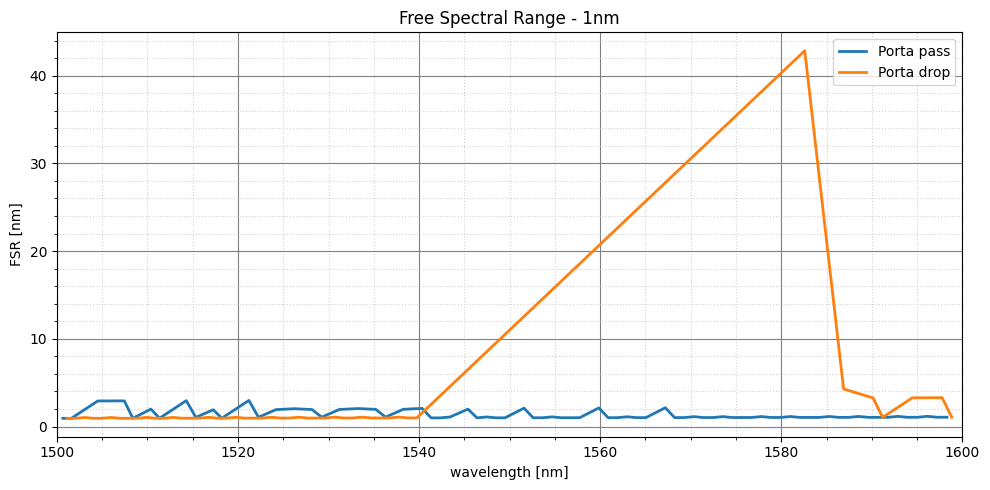

In [152]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range - 1nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 1nm.png')
plt.show()

In [153]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_{N[0]}')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_{N[0]}')
interApi.setposition(f'Acoplador_Direcional_sup_{N[0]}', x_acoplador_direcional_sup, y_acoplador_direcional_sup)


for i in range(N[1]):
    interApi.select(f'Acoplador_Direcional_inf_{N[i]}')
    interApi.delete()
    
    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_inf_{N[i]}')
    interApi.setposition(f'Acoplador_Direcional_inf_{N[i]}', x_acoplador_direcional_inf, y_acoplador_direcional_inf + i*2*distancia)

In [154]:
for i in range(N[1]):
    interApi.select(f'WGD_esquerdo_{N[i]}')
    interApi.delete()
    interApi.select(f'WGD_direito_{N[i]}')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_esquerdo_{N[i]}')
    interApi.setposition(f'WGD_esquerdo_{N[i]}', x_waveguide_esquerdo, y_waveguide_esquerdo + i*2*distancia)
    interApi.set('wg_length', Lc[[i],[1]])
    interApi.set('wg_width', wg_width)
    interApi.set('Rotated', 45)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_direito_{N[i]}')
    interApi.setposition(f'WGD_direito_{N[i]}', x_waveguide_direito, y_waveguide_direito + i*2*distancia)
    interApi.set('wg_length', Lc[[i],[1]])
    interApi.set('wg_width', wg_width)
    interApi.set('Rotated', 45)

In [155]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_{N[0]}', 'opt_1')
for i in range (N[1]):
	if i == 0:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')
	
	elif N[i] > 1:
		interApi.connect(f'Acoplador_Direcional_inf_{N[i-1]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_inf_{N[i-1]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')
	
	else:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_{N[0]}', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_{N[i]}', 'opt_4', 'ONA', 'input 2')

1.0

In [156]:
interApi.save(file)

In [157]:
interApi.run(1)

In [158]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
transmission_1 = np.array(FSR_1["'TE' gain (dB)"])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
transmission_2 = np.array(FSR_2["'TE' gain (dB)"])

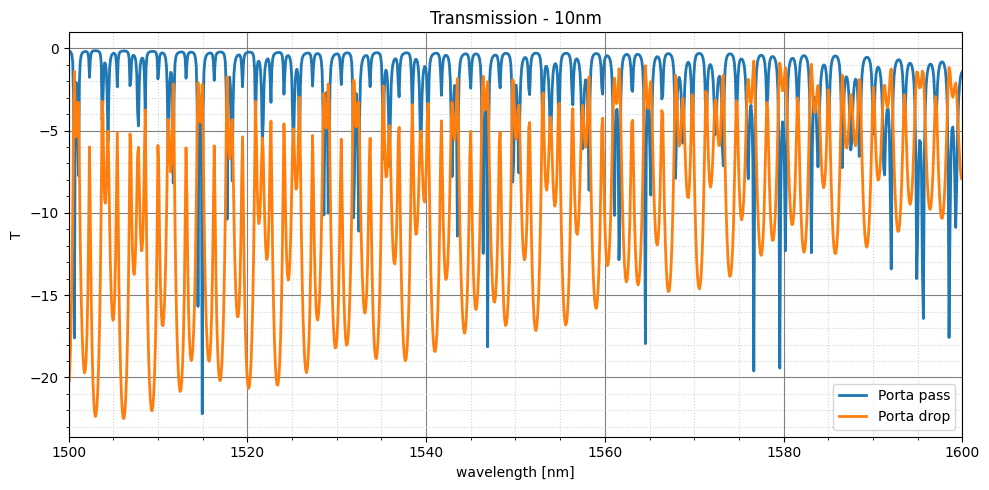

In [159]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - 10nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 10nm.png')
plt.show()

In [160]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_10 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_10 = np.array(FSR_1["'TE' free spectral range (m)"])

wavelength_2_10 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_10 = np.array(FSR_2["'TE' free spectral range (m)"])   

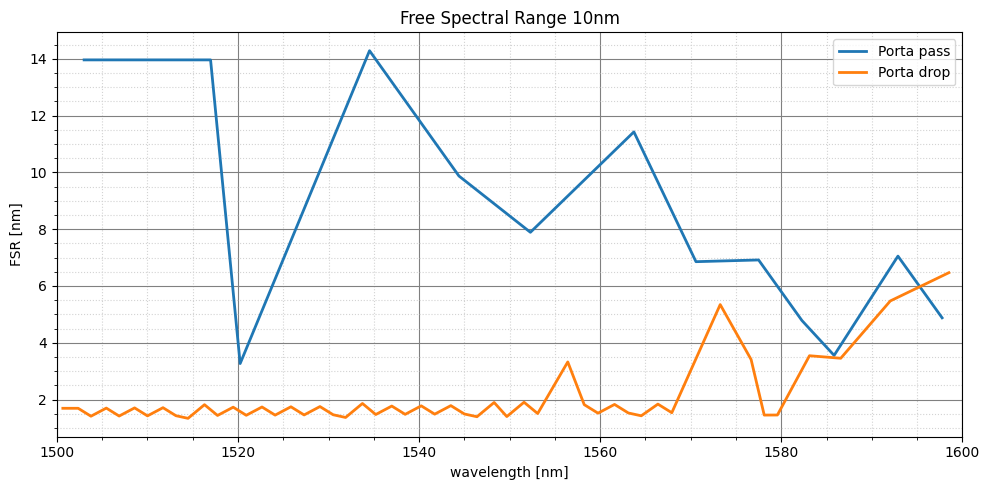

In [161]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range 10nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 10nm.png')
plt.show()

In [162]:
interApi.switchtolayout()

interApi.select(f'Acoplador_Direcional_sup_{N[0]}')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', f'Acoplador_Direcional_sup_{N[0]}')
interApi.setposition(f'Acoplador_Direcional_sup_{N[0]}', x_acoplador_direcional_sup, y_acoplador_direcional_sup)


for i in range(N[1]):
    interApi.select(f'Acoplador_Direcional_inf_{N[i]}')
    interApi.delete()
    
    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_inf_{N[i]}')
    interApi.setposition(f'Acoplador_Direcional_inf_{N[i]}', x_acoplador_direcional_inf, y_acoplador_direcional_inf + i*2*distancia)

In [163]:
for i in range(N[1]):
    interApi.select(f'WGD_esquerdo_{N[i]}')
    interApi.delete()
    interApi.select(f'WGD_direito_{N[i]}')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_esquerdo_{N[i]}')
    interApi.setposition(f'WGD_esquerdo_{N[i]}', x_waveguide_esquerdo, y_waveguide_esquerdo + i*2*distancia)
    interApi.set('wg_length', Lc[[i],[1]])
    interApi.set('wg_width', wg_width)
    interApi.set('Rotated', 45)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_direito_{N[i]}')
    interApi.setposition(f'WGD_direito_{N[i]}', x_waveguide_direito, y_waveguide_direito + i*2*distancia)
    interApi.set('wg_length', Lc[[i],[1]])
    interApi.set('wg_width', wg_width)
    interApi.set('Rotated', 45)

In [164]:
interApi.connect('ONA', 'output', f'Acoplador_Direcional_sup_{N[0]}', 'opt_1')
for i in range (N[1]):
	if i == 0:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')
	
	elif N[i] > 1:
		interApi.connect(f'Acoplador_Direcional_inf_{N[i-1]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_inf_{N[i-1]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')
	
	else:
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_2', f'WGD_esquerdo_{N[i]}', 'port 1')
		interApi.connect(f'Acoplador_Direcional_sup_{N[i]}', 'opt_4', f'WGD_direito_{N[i]}', 'port 1')
		interApi.connect(f'WGD_esquerdo_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_1')
		interApi.connect(f'WGD_direito_{N[i]}', 'port 2', f'Acoplador_Direcional_inf_{N[i]}', 'opt_3')

interApi.connect(f'Acoplador_Direcional_sup_{N[0]}', 'opt_3', 'ONA', 'input 1')
interApi.connect(f'Acoplador_Direcional_inf_{N[i]}', 'opt_4', 'ONA', 'input 2')

1.0

In [165]:
interApi.save(file)

In [166]:
interApi.run(1)

In [167]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
transmission_1 = np.array(FSR_1["'TE' gain (dB)"])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
transmission_2 = np.array(FSR_2["'TE' gain (dB)"])  

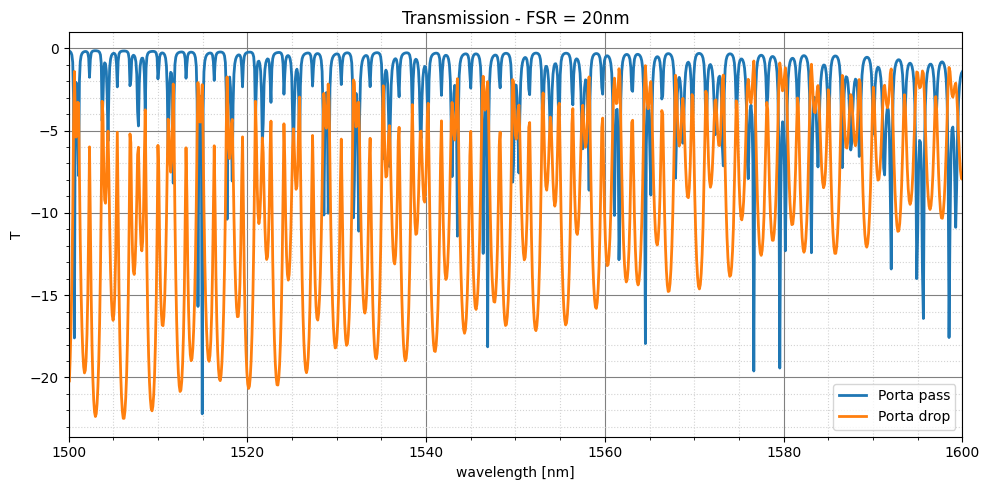

In [168]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - FSR = 20nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 20nm.png')
plt.show()

In [169]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_20 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_20 = np.array(FSR_1["'TE' free spectral range (m)"])

wavelength_2_20 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_20 = np.array(FSR_2["'TE' free spectral range (m)"])  

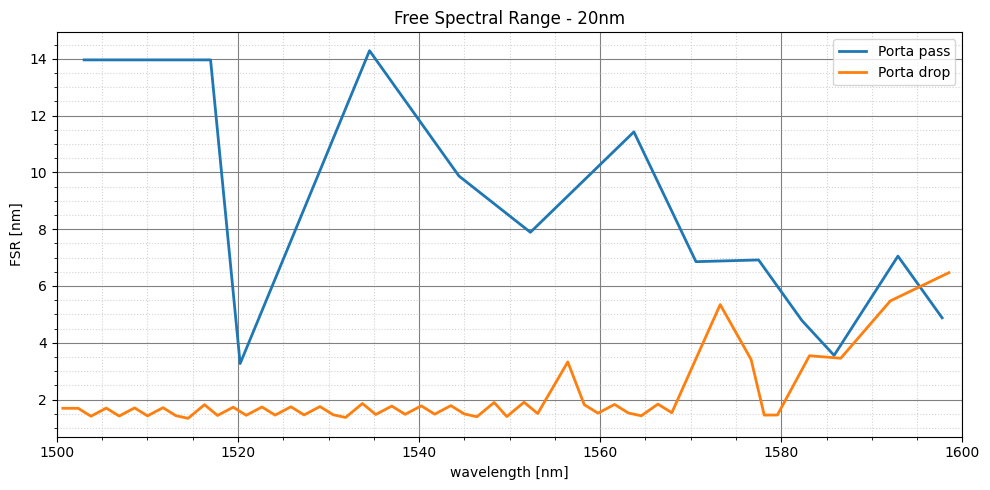

In [170]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range - 20nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 20nm.png')
plt.show()

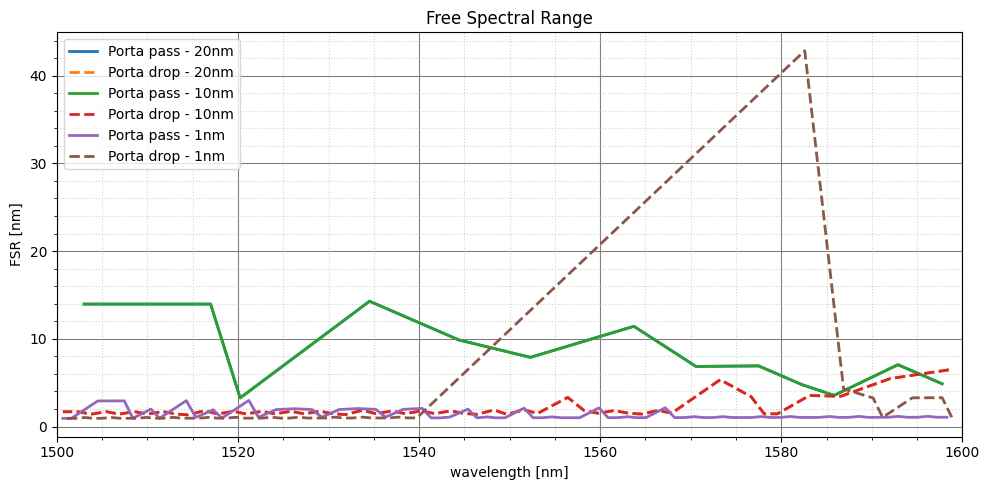

In [171]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass - 20nm', linewidth=2)
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop - 20nm', linewidth=2, linestyle='--')
plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass - 10nm', linewidth=2)
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop - 10nm', linewidth=2, linestyle='--')
plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass - 1nm', linewidth=2)
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop - 1nm', linewidth=2, linestyle='--')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR.png')
plt.show()